In [1]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from scipy import stats
from scipy import integrate
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from brokenaxes import brokenaxes
import matplotlib.ticker as ticker

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Inputs

In [73]:
Pinputs_FoodSector_dict = {'Fertilizer supply':55.8*1E6,
              'Animal feed':21.8*1E6,
              'Aquaculture feed':0.07*1E6,}

Pinputs_FoodSector_df = pd.DataFrame.from_dict(Pinputs_FoodSector_dict, orient='index', columns=['kg P'])

Pinputs_FoodSector_df.loc['Total P inputs'] = Pinputs_FoodSector_df.sum(axis=0)

Pinputs_FoodSector_df

,kg P
Fertilizer supply,55800000.0
Animal feed,21800000.0
Aquaculture feed,70000.0
Total P inputs,77670000.0


### Outputs

In [165]:
Results_df = pd.read_csv('Results/PRecoveryAndCosts/Results_PlotSummary.csv', sep=",", header=0, index_col=0)
Results_df.loc['Total recoverable P'] = Results_df.sum(axis=0)
Results_df

,Minimum recovery cost (EUR/year),Maximum recovery cost (EUR/year),Minimum P recovered (kg P/year),Maximum P recovered (kg P/year),Minimum P recovery cost (EUR/kg P recovered),Maximum P recovery cost (EUR/kg P recovered),Minimum P recovered (% over inflow),Maximum P recovered (% over inflow)
Cattle manure (liquid),7.794768e+08,7.794768e+08,2.389290e+06,2.389290e+06,326.237803,326.237803,18.000000,18.0
Swine manure (liquid),3.063805e+08,3.063805e+08,1.542337e+06,1.542337e+06,198.646906,198.646906,18.000000,18.0
Poultry manure (liquid),4.570184e+08,4.570184e+08,1.162233e+06,1.162233e+06,393.224381,393.224381,18.000000,18.0
Other livestock manure (liquid),2.838011e+08,2.838011e+08,4.109198e+05,4.109198e+05,690.648414,690.648414,18.000000,18.0
Cattle manure (solid),8.521802e+07,9.230625e+07,7.964301e+06,8.097039e+06,10.700000,11.400000,60.000000,61.0
Swine manure (solid),5.501002e+07,5.958562e+07,5.141123e+06,5.226809e+06,10.700000,11.400000,60.000000,61.0
Poultry manure (solid),4.145298e+07,4.490093e+07,3.874110e+06,3.938678e+06,10.700000,11.400000,60.000000,61.0
Other livestock manure (solid),1.465614e+07,1.587520e+07,1.369733e+06,1.392562e+06,10.700000,11.400000,60.000000,61.0
WWTPs (liquid),1.604064e+06,1.538674e+07,2.558449e+05,4.453596e+05,6.269672,34.549037,27.000008,47.0
WWTPs (sludge),4.865321e+07,5.273458e+07,4.964613e+06,5.022341e+06,9.800000,10.500000,86.000000,87.0


In [167]:
(Results_df.loc['Total recoverable P']['Minimum recovery cost (EUR/year)']/
Results_df.loc['Total recoverable P']['Minimum P recovered (kg P/year)'])

35.83317252179859

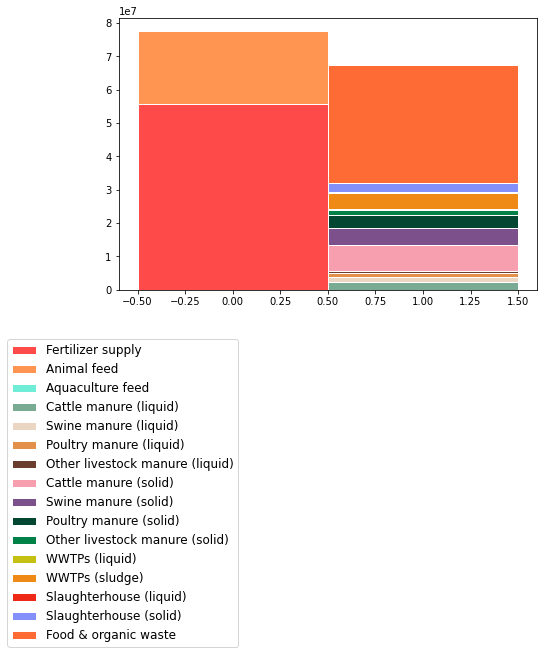

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(7.5,5),)

r = np.arange(0,2,1)
barWidth = 1
                       
color_inflows = ['#FF4A4A','#FF9551','#6FEDD6']

count = 0
bottom_list1 = []

for index, row in Pinputs_FoodSector_df.iloc[:].iterrows():
    inflow = Pinputs_FoodSector_df.loc[index]['kg P']

    bottom1 = (0 if count == 0 else Pinputs_FoodSector_df.iloc[count-1]['kg P'])
    bottom_list1.append(bottom1)
    
    ax.bar(r[0], inflow, color=color_inflows[count], bottom=sum(bottom_list1),
           edgecolor='white', width=barWidth)
    count = count +1
                       
color_outflows = ['#78AA94',
        '#EAD6C3',
        '#E3904A',
       '#6A3D2E',
        '#F89FAF',
        '#7C508A',
        '#034732',
        '#008148',
        '#C6C013',
        '#EF8A17',
        '#EF2917',
        '#8390FA',
        '#FF6B35',
        '#42C2FF',
       ]

count = 0
bottom_list2 = []
for index, row in Results_df.iterrows():
    outflow = Results_df.loc[index]['Minimum P recovered (kg P/year)']
    
    bottom2 = (0 if count == 0 else Results_df.iloc[count-1]['Minimum P recovered (kg P/year)'])
    bottom_list2.append(bottom2)
    
    ax.bar(r[1], outflow, color=color_outflows[count], bottom=sum(bottom_list2),
           edgecolor='white', width=barWidth)
    count = count +1
    
Flows_list = Pinputs_FoodSector_df.index.to_list()+Results_df.index.to_list()
names_flows = [Flows_list[i] for i in np.arange(0,len(Flows_list),1)]
ax.legend(names_flows, loc='upper right', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.3, -0.16))

plt.savefig('Results/PSubstitution/PSubstitution.pdf', bbox_inches='tight',)
    
# fig.legend(bbox_to_anchor=(0.9,0.6), prop={'size':9}, framealpha=0.5)


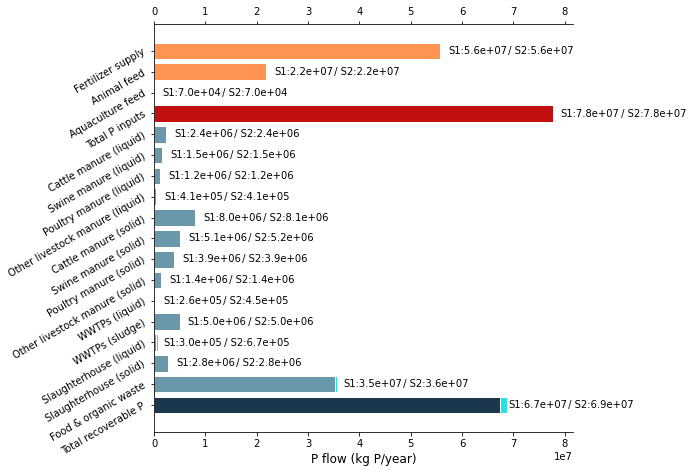

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(7.5,7.5),)

Flows_list = Pinputs_FoodSector_df.index.to_list()+Results_df.index.to_list()

# r = np.arange(0,len(Pinputs_FoodSector_df.index.to_list()),1)
r = np.arange(0,len(Flows_list),1)

barWidth = 0.8
                       
color_inflows = ['#FF9551']*(len(Pinputs_FoodSector_df.index)-1)+['#C21010']#,'#6FEDD6']
color_outflows = ['#6998AB']*(len(Results_df.index)-1)+['#1A374D']

count = 0
bottom_list1 = []

# for index, row in Pinputs_FoodSector_df.iloc[:].iterrows():
# inflow = Pinputs_FoodSector_df.loc[index]['kg P']

# bottom1 = (0 if count == 0 else Pinputs_FoodSector_df.iloc[count-1]['kg P'])
# bottom_list1.append(bottom1)

inflows = Pinputs_FoodSector_df['kg P'].to_list()
outflows = Results_df['Minimum P recovered (kg P/year)'].to_list()
flows = inflows + outflows

bars_flows = ax.barh(r[::-1], flows, color=color_inflows+color_outflows, #To reverse bars positioning
       edgecolor='white', height=barWidth)



r2 = r[::-1][len(Pinputs_FoodSector_df.index.to_list()):]
outflows_Scenario2 = [i-ii for i,ii in zip(Results_df['Maximum P recovered (kg P/year)'].to_list(),outflows)]
color_outflows_Scenario2 = ['#21E1E1']

bars_outflows2 = ax.barh(r2, outflows_Scenario2, color=color_outflows_Scenario2, left=outflows, #To reverse bars positioning
       edgecolor='white', height=barWidth)


ax.bar_label(bars_flows, labels=['S1:%.1e' % e for e in flows], fmt='%.1e', padding=8) #fmt='%.1e',
ax.bar_label(bars_flows,
             labels=[' / S2:%.1e' % e for e in inflows+Results_df['Maximum P recovered (kg P/year)'].to_list()],
             fmt='%.1e', padding=65) #fmt='%.1e',


ax.set_yticks(r[::-1])
# ax1.set_xticklabels(squad, minor=False, rotation=45)
ax.set_yticklabels(Flows_list)
ax.yaxis.set_tick_params(rotation=30)

ax.spines['right'].set_visible(False)
ax.tick_params(top=True, labeltop=True,)

ax.set_xlabel("P flow (kg P/year)", fontsize=12)

plt.savefig('Results/PSubstitution/PSubstitution.pdf', bbox_inches='tight',)
    
# fig.legend(bbox_to_anchor=(0.9,0.6), prop={'size':9}, framealpha=0.5)


In [109]:
r[::-1][len(Pinputs_FoodSector_df.index.to_list()):]

array([13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [45]:
# All this part is like the code above
VALUES = df["value"].values
LABELS = df["name"].values
GROUP = df["group"].values

PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [10, 20, 12, 8]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [10, 20, 12, 8]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size in zip(["A", "B", "C", "D"], GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=14, 
        fontweight="bold", ha="center", va="center"
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [80] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD

2389290.292020822